# 网络可视化
在这里，我们将探索使用“图像梯度”生成新图像。

在训练模型时，我们定义了一个损失函数，用来衡量我们目前对模型性能的不满。然后，我们使用反向传播来计算损失相对于模型参数的梯度，并对模型参数执行梯度下降以最小化损失。

在这里，我们将做一些稍微不同的事情。我们将从CNN模型开始，该模型已被预训练以在ImageNet数据集上执行图像分类。我们将使用这个模型来定义一个损失函数，该函数量化我们当前对自己的图像的不满。然后，我们将使用反向传播来计算这种损失相对于图像像素的梯度。然后，我们将保持模型固定，并对图像*执行梯度下降*，以合成将损失最小化的新图像。

我们将探讨图像生成的三种技术。
**显著性映射**我们可以使用显著性映射来判断图像的哪个部分影响了网络做出的分类决策。

**欺骗图像**我们可以干扰输入图像，使其对人类看起来相同，但会被预训练的网络错误分类。

**类可视化**我们可以合成一张图像，以最大化特定类的分类得分；这可以让我们了解网络在对该类别的图像进行分类时所寻找的内容。

In [1]:
# Setup cell.

import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from dlcv.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from dlcv.net_visualization_pytorch import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

C:\Users\xiandan\miniconda3\envs\d2l\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\xiandan\miniconda3\envs\d2l\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\xiandan\miniconda3\envs\d2l\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# 预训练模型
对于我们所有的图像生成实验，我们将从卷积神经网络开始，该网络经过预训练，可以在ImageNet上执行图像分类。我们可以在这里使用任何模型，但出于本任务的目的，我们将使用SqueezeNet[1]，它实现了与AlexNet相当的精度，但显著降低了参数计数和计算复杂性。

使用SqueezeNet而不是AlexNet、VGG或ResNet意味着我们可以在CPU上轻松地执行所有图像生成实验。

[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

In [2]:
# Download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to C:\Users\xiandan/.cache\torch\hub\checkpoints\squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

## 加载ImageNet验证图像

我们提供了ImageNet ILSVRC 2012分类数据集验证集中的一些示例图像。由于它们来自验证集，我们的预训练模型在训练过程中没有看到这些图像。运行以下单元格，将其中一些图像及其实况标签可视化。

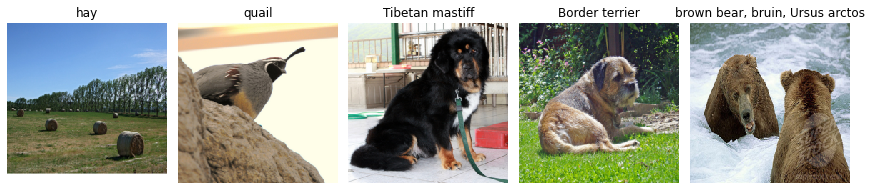

In [3]:
from dlcv.data_utils import load_imagenet_val
X, y, class_names = load_imagenet_val(num=5)
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

# 显著性地图
使用这个预训练的模型，我们将计算类显著性图，如[2]的第3.1节所述。

**显著性图**告诉我们图像中的每个像素对该图像的分类得分的影响程度。为了计算它，我们计算与正确类别（它是标量）相对应的未规范化分数相对于图像像素的梯度。如果图像具有形状“（3，H，W）”，则该梯度也将具有形状“3，H、W）”；对于图像中的每个像素，这个梯度告诉我们，如果像素变化很小，分类得分将变化多少。为了计算显著性图，我们取该梯度的绝对值，然后取3个输入通道上的最大值；最终显著性映射因此具有形状“（H，W）”并且所有条目都是非负的。

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

In [4]:
import numpy as np
s=np.random.rand(2,3)
print(s)
myy=np.array([1,2])
print(s[np.arange(2),myy])#提取array中每一行不同元素的方法
print(np.arange(9))
t=torch.rand((3,3,3))
print(t)
tt,_=torch.max(t,1,True)
print(tt.squeeze())

[[0.70831237 0.53097645 0.49673407]
 [0.58300487 0.93321312 0.98037023]]
[0.53097645 0.98037023]
[0 1 2 3 4 5 6 7 8]
tensor([[[0.9726, 0.6864, 0.4128],
         [0.3508, 0.8976, 0.6772],
         [0.3036, 0.7918, 0.9972]],

        [[0.6268, 0.4921, 0.0426],
         [0.3542, 0.1529, 0.5217],
         [0.3669, 0.2567, 0.1467]],

        [[0.9511, 0.5020, 0.6358],
         [0.0185, 0.9920, 0.0971],
         [0.7741, 0.4292, 0.0166]]])
tensor([[0.9726, 0.8976, 0.9972],
        [0.6268, 0.4921, 0.5217],
        [0.9511, 0.9920, 0.6358]])


### 提示：PyTorch“聚集”方法

回想一下作业1，你需要从矩阵的每一行中选择一个元素；如果“s”是形状“（N，C）”的numpy数组，并且“y”是包含整数“0<=y[i]<C”的形状“（N，”）的numpy阵列，则“s[np.arange（N），y]'是形状“N，）”的numpy数组，其使用“y”中的索引从“s”中的每个元素中选择一个元素。

在PyTorch中，您可以使用“gather（）”方法执行相同的操作。如果“s”是形状为“（N，C）”的PyTorch张量，并且“y”是包含范围为“0<=y[i]<C”的长的形状为“

`s.collect（1，y.view（-1，1））.sruzze（）`

将是形状为“（N，）”的PyTorch张量，包含根据“y”中的索引选择的“s”的每行中的一个条目。
运行以下单元格查看示例。

您也可以阅读[the gather method](http://pytorch.org/docs/torch.html#torch.gather)
和 [the squeeze method](http://pytorch.org/docs/torch.html#torch.squeeze).

In [5]:
# Example of using gather to select one entry from each row in PyTorch
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

tensor([[ 2.1317e+00, -5.8110e-02, -1.3234e+00,  4.5222e-01, -2.6647e-01],
        [ 5.7634e-01, -8.2752e-01, -6.3053e-02, -6.1030e-01, -1.7917e+00],
        [-9.5989e-01, -6.7854e-04, -1.1642e+00,  6.2794e-01,  5.4947e-01],
        [ 2.6659e-01, -6.2208e-01,  2.4372e-01,  1.1639e+00, -2.2952e+00]])
tensor([1, 2, 1, 3])
tensor([-5.8110e-02, -6.3053e-02, -6.7854e-04,  1.1639e+00])


Implement ```compute_saliency_maps``` function inside ```dlcv/net_visualization_pytorch.py```

一旦您完成了上面的实现，请运行以下操作，在ImageNet验证集的示例图像上可视化一些类显著性映射：

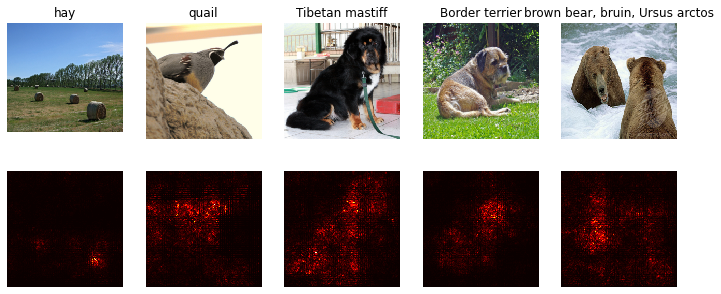

In [6]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)
    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)

# 问题1

你的一位朋友建议，为了找到一张能最大化正确分数的图像，我们可以对输入图像进行梯度提升，但实际上我们可以在每一步中使用显著性图来更新图像，而不是梯度。这个断言是真的吗？为什么？

**要对梯度提升、显著性图这两个概念重新回顾。梯度提升呢是利用图形的梯度信息更新图像，目的是通过梯度方向的变化来最小化目标函数，GAN网络中梯度提升是通过反向传播优化器来生成具有特定特征的图像；显著性图是基于图像内容像素重要性的评估，可以指示图像中哪些区域/部分值得我们去关注，但是不提供关于如何更新图像的具体信息的方式，因此不能使用显著性图更新图像**

# 欺骗图像
我们还可以使用图像梯度来生成[3]中讨论的“欺骗图像”。给定图像和目标类别，我们可以在图像上执行梯度**上升**，以最大化目标类别，当网络将图像分类为目标类别时停止。实现以下功能以生成欺骗图像。

[3] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

Implement ```make_fooling_image``` function inside ```dlcv/net_visualization_pytorch.py```

运行以下单元格以生成一个欺骗图像。理想情况下，你应该第一眼看到原始图像和欺骗图像之间没有重大区别，网络现在应该对欺骗图像做出错误的预测。然而，如果你观察原始图像和伪图像之间的10倍放大差异，你应该会看到一些随机噪声。请随意更改“idx”变量以浏览其他图像。

In [7]:
idx = 0
target_y = 6

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0].item(), 'The model is not fooled!'

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9


生成欺骗图像后，运行以下单元格以可视化原始图像、愚弄图像以及它们之间的差异。

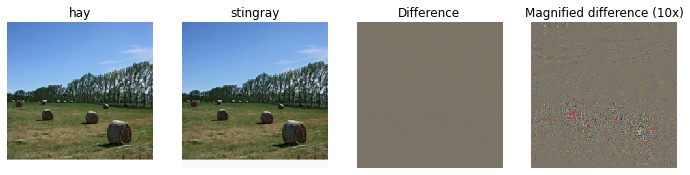

In [8]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

# 类可视化
通过从随机噪声图像开始，并对目标类别执行梯度上升，我们可以生成网络将识别为目标类别的图像。这个想法最早出现在[2]中；[3] 通过提出几种可以提高生成图像质量的正则化技术来扩展这一思想。
具体地说，让$I$是一个图像，让$y$是目标类。设$s_y（I）$是卷积网络为类$y$的图像$I$分配的分数；请注意，这些是未规范化的原始分数，而不是类概率。我们希望生成一个图像$I^*$，通过解决问题为类$y$获得高分

$$
I^* = \arg\max_I (s_y(I) - R(I))
$$

其中$R$是一个（可能是隐式的）正则化子（注意argmax中$R（I）$的符号：我们希望最小化这个正则化项）。我们可以使用梯度上升来解决这个优化问题，计算相对于生成的图像的梯度。我们将使用形式的（显式）L2正则化

$$
R(I) = \lambda \|I\|_2^2
$$

**以及通过周期性地模糊生成的图像来**如[3]所建议的隐式正则化。我们可以在生成的图像上使用梯度上升来解决这个问题。

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[3] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [9]:
def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.

    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations

    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))
        class_visualization_update_step(img, model, target_y, l2_reg, learning_rate)
        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)

        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.data.cpu())

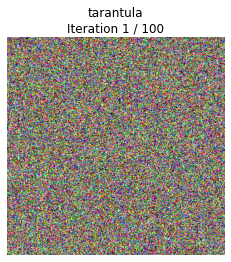

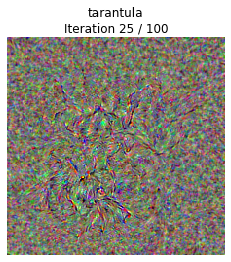

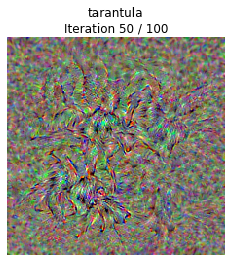

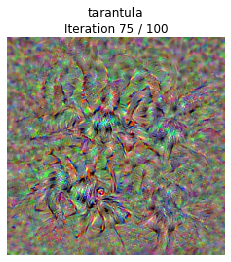

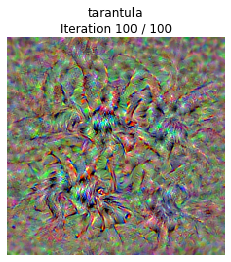

In [10]:
dtype = torch.FloatTensor
model.type(dtype)

target_y = 76 # Tarantula
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
out = create_class_visualization(target_y, model, dtype)

在其他课程上尝试您的课程可视化！您也可以随意使用各种超参数来尝试提高生成图像的质量，但这不是必需的。

basketball


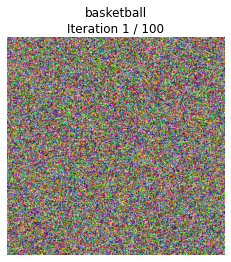

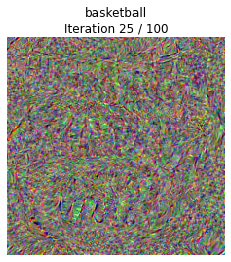

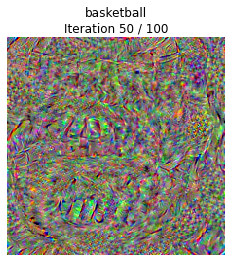

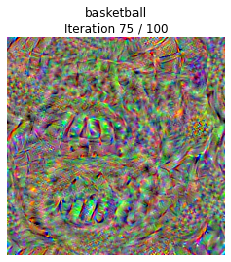

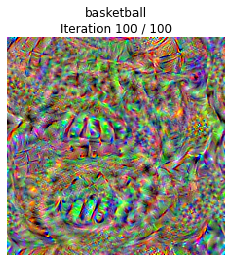

In [11]:
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
target_y = np.random.randint(1000)
print(class_names[target_y])
X = create_class_visualization(target_y, model, dtype)